# (08) MNIST — Poisson — 1

**Motivation**: Implement Poisson VAE, fit to MNIST. Note: this notebook used straight-through (ST) gradient estimator. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 100
activation = 'exp'
weight_norm = True

batch_size = 200
epochs = 300

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pvaest',
    device_idx=1,
    n_latents=n_latents,
    activation=activation,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=0.5,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonVAEST |  7.9 Mil   |
|     ---      |    ---     |
|     enc      |  6.6 Mil   |
|     dec      |  1.3 Mil   |
+--------------+------------+

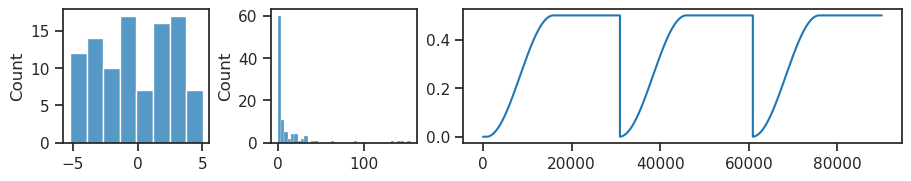

In [4]:
fig, axes = create_figure(1, 3, (9, 1.7), width_ratios=[1, 1, 3], layout='constrained')

sns.histplot(to_np(pvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['beta_values'])
plt.show()

## Train / Validate

### trn

In [5]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    out = iteration(ep, pvae, trn, optim, optim_schedule, device, **kws_iter)
    if out is None:
        break
    else:
        grad, tot, recon, kl = out
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 137.0,  loss = (kl: 19.3, recon: 18.3  ——  tot: 27.95)  : 100%|████████████████████████| 300/300 [1:01:40<00:00, 12.33s/it]

CPU times: user 1h 32min 23s, sys: 35.7 s, total: 1h 32min 59s
Wall time: 1h 1min 40s


### vld

In [7]:
emb, labels, loss_vld = validate(pvae, vld, device)
loss_vld

{'kl': 19.1656529296875, 'recon': 19.26348425292969, 'tot': 28.846310693359374}

In [6]:
### Was with self.dt included

{'kl': 11.251917700195316,
 'recon': 25.719287695312495,
 'tot': 36.97120537109375}

{'kl': 16.8618673828125, 'recon': 20.324040893554688, 'tot': 30.44116162109375}

In [6]:
### was n_latents=1000, beta=0.4 (batch_size=2000)

{'kl': 17.1463421875, 'recon': 20.148307421875, 'tot': 30.436112890624997}

In [6]:
### was n_latents=100, beta=0.4 (batch_size=2000)

{'kl': 22.665241015625, 'recon': 17.23217265625, 'tot': 26.298269531250003}

In [6]:
### was n_latents=100, beta=0.5 (batch_size=2000)

{'kl': 17.4222859375, 'recon': 21.583405078125004, 'tot': 30.294548046875}

In [7]:
### was n_latents=100, beta=0.5

{'kl': 19.09686728515625, 'recon': 18.90309638671875, 'tot': 28.451530078125}

In [6]:
### was n_latents=100, beta=0.7 (current best)

{'kl': 15.100736767578127,
 'recon': 21.252682226562495,
 'tot': 31.8231974609375}

In [7]:
### was n_latents=100, beta=2.0

{'kl': 5.22959970703125, 'recon': 33.51797529296876, 'tot': 43.977175195312505}

In [11]:
### was n_latents=100, beta=1.0

{'kl': 11.18375390625, 'recon': 24.6592642578125, 'tot': 35.843018359375}

In [6]:
### was n_latents=100, beta=1.0

{'kl': 11.0060966796875,
 'recon': 24.946016992187502,
 'tot': 35.952113671875004}

In [5]:
### was n_latents=100, beta=1.0

{'kl': 11.7849951171875, 'recon': 23.6866322265625, 'tot': 35.47162773437499}

In [5]:
### was n_latents=1000

{'kl': 11.121812548828125,
 'recon': 25.44308349609375,
 'tot': 36.564896093749994}

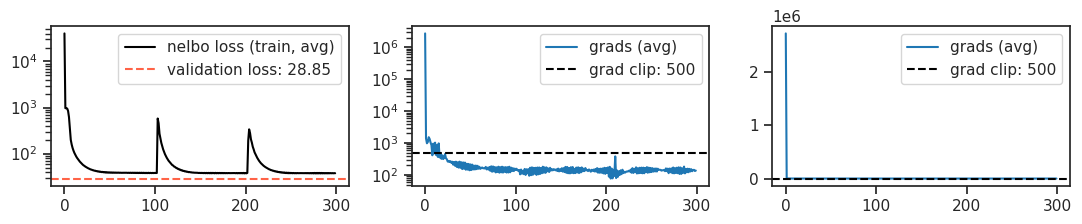

In [8]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=60)
plt.show()

In [9]:
spks, r_q, r_p, r_qp = [], [], [], []

for x, _ in iter(vld):
    x = x.to(device)

    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['r_q']))
    r_p.append(to_np(out['r_p']))
    r_qp.append(to_np(out['r_q'] * out['r_p']))

spks, r_q, r_p, r_qp = cat_map([spks, r_q, r_p, r_qp])

In [10]:
np.quantile(spks.ravel(), 0.99)

657.0

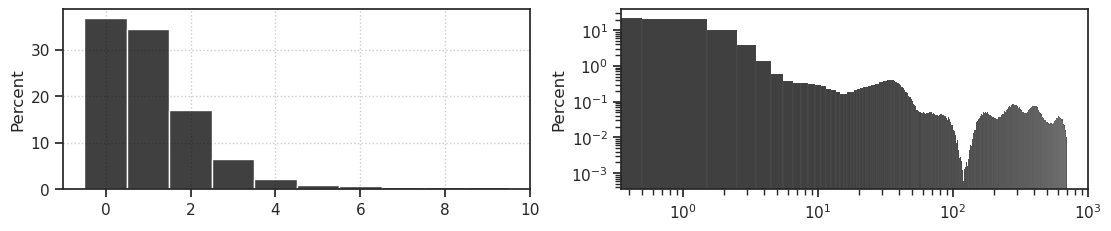

In [12]:
fig, axes = create_figure(1, 2, (11, 2.2), layout='constrained')

nbins = 10
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 700
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

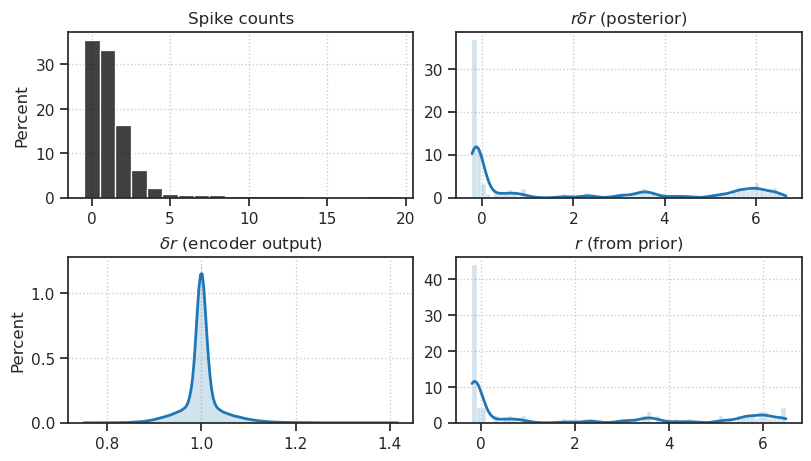

In [13]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 20
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
sns.histplot(np.log(r_p.ravel()), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

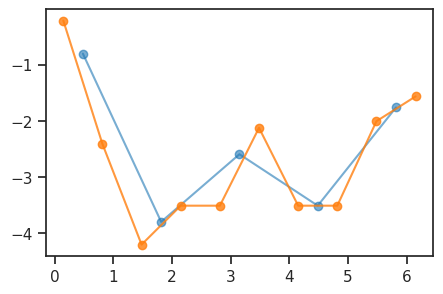

In [14]:
nbins_list = [5, 10]
for i, bins in enumerate(nbins_list):

    hist, bin_edges = np.histogram(np.log(r_p.ravel()), bins=bins, density=True)
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.plot(x, np.log(hist), marker='o', color=f'C{i}', alpha=1.0 - (len(nbins_list) - i) * 0.2)

In [15]:
from torchvision.utils import make_grid

x_samples = pvae.sample(50)

grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 152, 302])

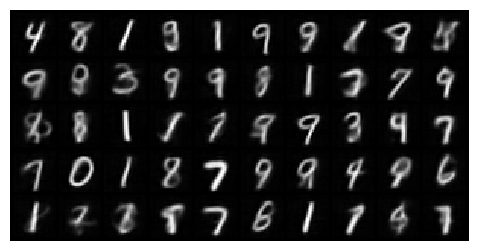

In [16]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (10, 3))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

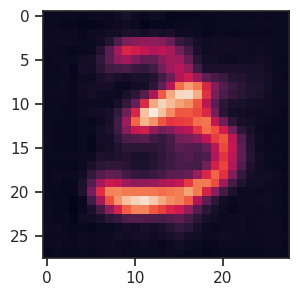

In [17]:
plt.imshow(to_np(x_samples[12].squeeze()));

In [18]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = pvae(x)

In [19]:
num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

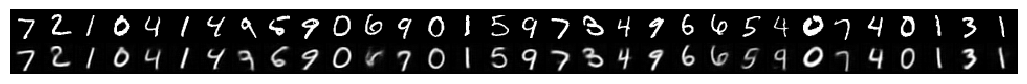

In [20]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

In [21]:
uu, ss, vv = sp_lin.svd(emb, full_matrices=False)
ss *= 100 / sum(ss)
ss.shape

(100,)

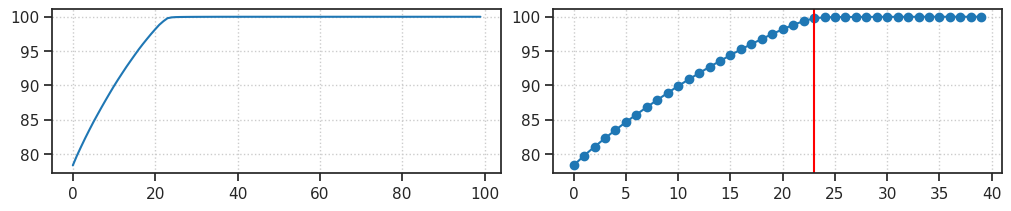

In [27]:
fig, axes = create_figure(1, 2, (10, 2), layout='constrained')
axes[0].plot(np.cumsum(ss))
axes[1].plot(np.cumsum(ss)[:40], marker='o')
axes[1].axvline(23, color='r')
add_grid(axes)
plt.show()

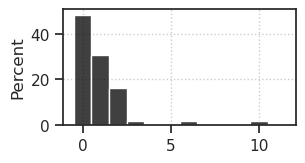

In [28]:
fig, ax = create_figure(1, 1, (3, 1.5))

sample_i = 90
nbins = 12
sns.histplot(spks[sample_i], color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=ax)
# ax.locator_params(axis='x', nbins=nbins+2)
ax.grid();

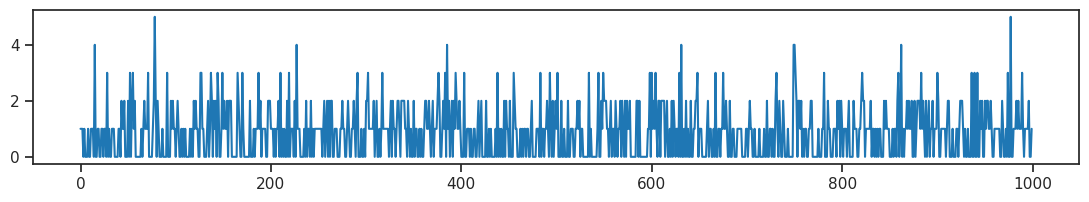

In [22]:
neuron_i = 17

fig, ax = create_figure(1, 1, (13.5, 2))
intvl = range(6000, 7000)
plt.plot(spks[intvl, neuron_i])
# plt.plot(spks[intvl, 6])
plt.show()

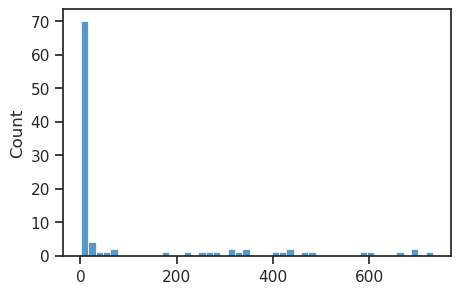

In [22]:
mean_spks = spks.mean(0)
sns.histplot(mean_spks);

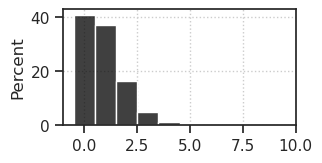

In [42]:
fig, ax = create_figure(1, 1, (3, 1.5))

neuron_i = 8
nbins = 10
sns.histplot(spks[:, neuron_i], color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=ax)
# ax.locator_params(axis='x', nbins=nbins+2)
ax.grid();

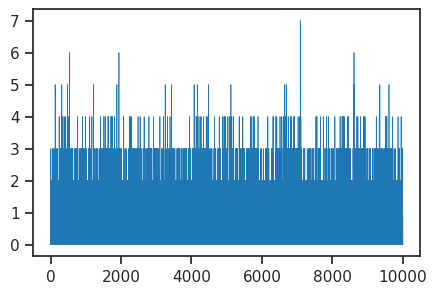

In [75]:
plt.plot(spks[:, 8], lw=0.5);

In [76]:
r_q.shape

(10000, 100)

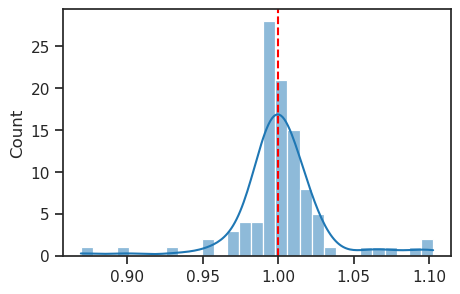

In [77]:
sample_i = 500
sns.histplot(r_q[sample_i], kde=True)
plt.axvline(1.0, color='r', ls='--');

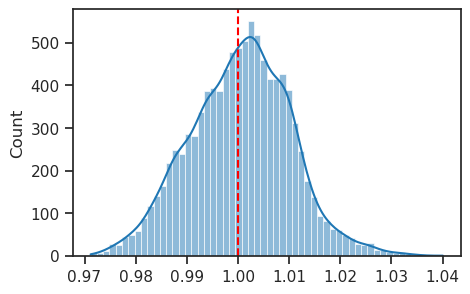

In [78]:
neuron_i = 8
sns.histplot(r_q[:, neuron_i], kde=True)
plt.axvline(1.0, color='r', ls='--');

In [79]:
for x, lbl in iter(vld):
    x = x.to(device)
    break

n_trials = 1000

spks, r_q, r_p, r_qp, x_recon = [], [], [], [], []
for _ in range(n_trials):
    with torch.inference_mode():
        out = pvae(x)

    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['r_q']))
    r_p.append(to_np(out['r_p']))
    r_qp.append(to_np(out['r_q'] * out['r_p']))
    x_recon.append(to_np(out['x_recon']))

spks, r_q, r_p, r_qp, x_recon = map(
    lambda arr: np.stack(arr),
    [spks, r_q, r_p, r_qp, x_recon],
)

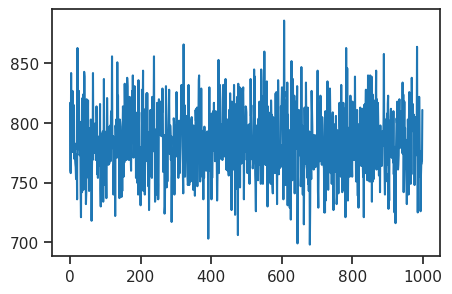

In [85]:
sample_i = 104
neuron_i = 5

plt.plot(spks[:, sample_i, neuron_i])

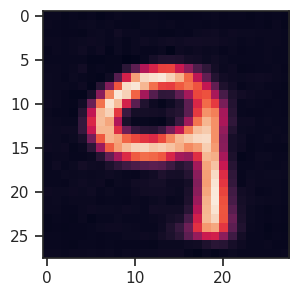

In [86]:
trial_i = 43
plt.imshow(x_recon[trial_i, sample_i, 0]);

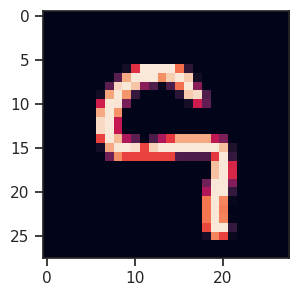

In [87]:
plt.imshow(to_np(x[sample_i, 0]));

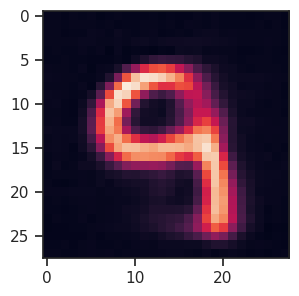

In [88]:
plt.imshow(x_recon[:, sample_i, 0].mean(0));

In [91]:
num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

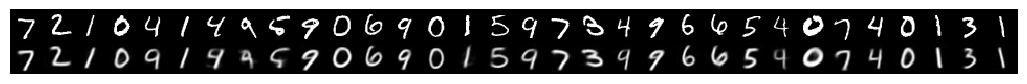

In [92]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

In [56]:
from base.distributions import softclamp

In [64]:
mean = 1.0
sigma = 2.0

rng = get_rng()
log_rates = rng.normal(
    loc=mean,
    scale=sigma,
    size=(10000,),
)
log_rates = torch.tensor(
    data=log_rates,
    dtype=torch.float,
)
log_rates = softclamp(log_rates, 5.3)

<Axes: ylabel='Count'>

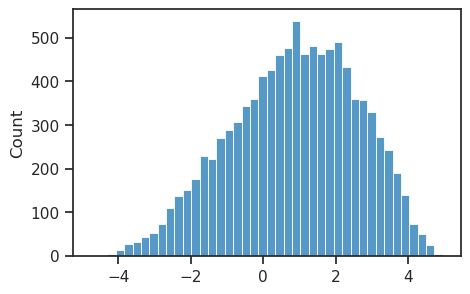

In [65]:
sns.histplot(log_rates)

<Axes: ylabel='Count'>

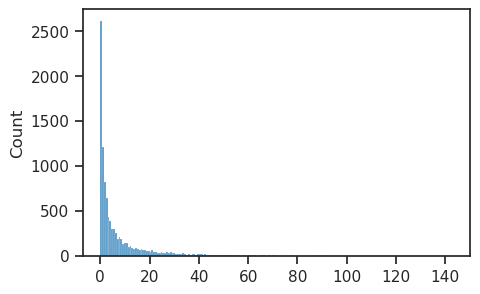

In [66]:
sns.histplot(np.exp(log_rates))

In [63]:
np.exp(5.3)

200.33680997479166

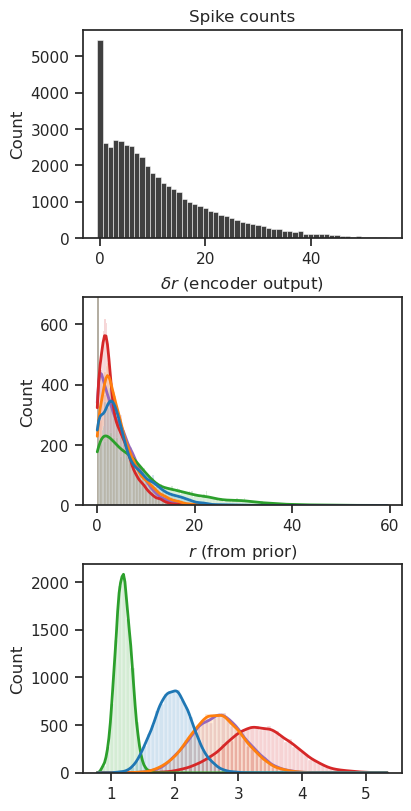

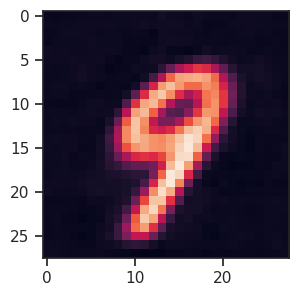

In [13]:
plt.imshow(to_np(out['x_recon'].squeeze()[7]));

### make some plots

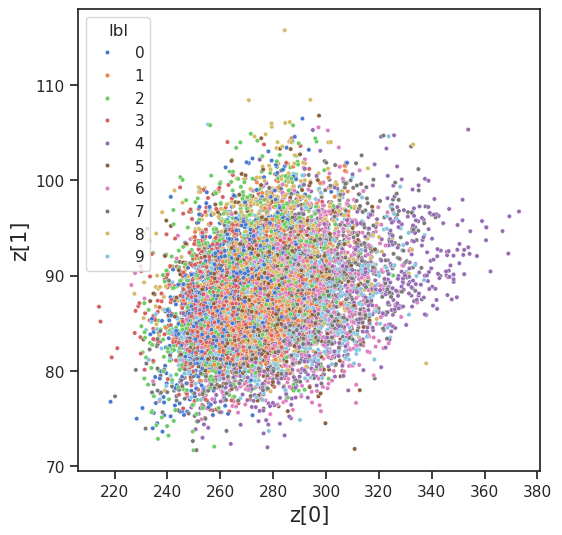

In [29]:
_ = plot_latent_scatter(emb, labels, (0, 3), figsize=(6, 6), s=10)

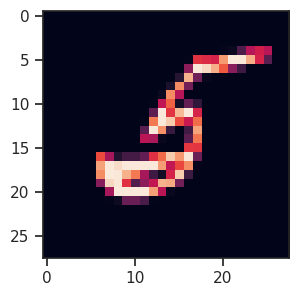

In [32]:
x, lbl = trn.dataset[1111]
plt.imshow(to_np(x)[0]);

In [33]:
with torch.inference_mode():
    out = gapvae(x.unsqueeze(0).to(device))

In [34]:
num = 10000
prior_r_p = torch.zeros((num, n_latents))
posterior_r_q = torch.zeros((num, n_latents))
posterior_r_qp = torch.zeros((num, n_latents))

for i in range(num):
    prior_r_p[i] = torch.poisson(out['r_p'][0])
    posterior_r_q[i] = torch.poisson(out['r_q'][0])
    posterior_r_qp[i] = torch.poisson(out['r_q'][0] * out['r_p'][0])

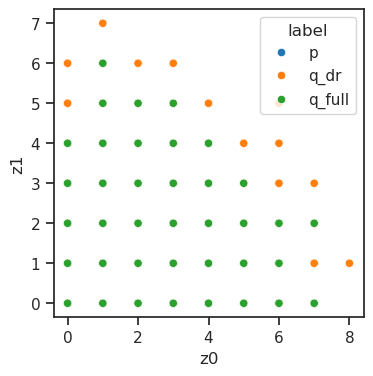

In [35]:
df = np.concatenate([prior_r_p, posterior_r_q, posterior_r_qp])
df = pd.DataFrame({
    'z0': df[:, 0],
    'z1': df[:, 1],
    'label': ['p'] * num + ['q_dr'] * num + ['q_full'] * num,
})

fig, ax = create_figure(1, 1, (4, 4))
sns.scatterplot(
    data=df,
    x='z0',
    y='z1',
    hue='label',
    palette={'p': 'C0', 'q_dr': 'C1', 'q_full': 'C2', },
    ax=ax,
)
plt.show()

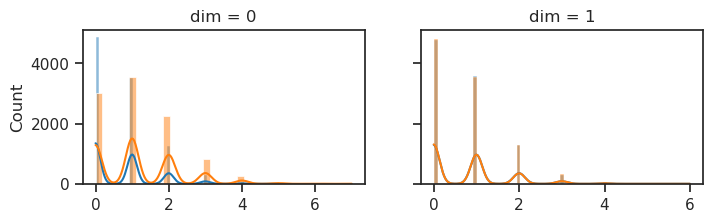

In [36]:
fig, axes = create_figure(1, 2, (8, 2), sharey='row')

for i in range(2):
    sns.histplot(prior_r_p[:, i], kde=True, ax=axes[i])
    sns.histplot(posterior_r_qp[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'dim = {i}')
plt.show()

In [21]:
# path = '/home/hadi/Documents/vae'

# torch.save(
#     obj={'epoch': epochs,
#          'batch_size': batch_size,
#          'model_state_dict': gvae.state_dict(),
#          'optimizer_state_dict': optim.state_dict(),
#          'loss': loss_vld},
#     f=pjoin(path, '1.pt'),
# )